<a href="https://colab.research.google.com/github/rdemarqui/studies/blob/master/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes

Example adapted from the excelent tutorial given by **Future Mojo** Channel. https://www.youtube.com/watch?v=FrWvpzoQBPQ

## Conditional Probability

$P(A \cap B) = P(A) \cdot P(B|A)$

*Probability of A and B, it's equal to probability of A times probability of B given A*

## Deriving Bayes Theorem

*Given:*

$P(A \cap B) = P(A) \cdot P(B|A)$

$P(B \cap A) = P(B) \cdot P(A|B)$

*and, according to commutativity of conjuntion:*

$P(A \cap B) = P(B \cap A)$

*so, replacing:*

$P(B) \cdot P(A|B) = P(A) \cdot P(B|A)$

*and dividing both sides by P(B), we have Bayes Theorem:*

$P(A|B) = \frac {P(A) \cdot P(B|A)} {P(B)}$


## Bayes Theorem

Replacing A and B by a hypotesis and data, we have:

$P(H|D) = \frac {P(H) \cdot P(D|H)} {P(D)}$

This is a probability of a hypotesis or belief being true given some observed data. Our belief could be adjusted as we get more data.

Where:
* $P(H|D)$ - Posterior probability
* $P(H)$ - Prior (belief before any evidence)
* $P(D|H)$ - Likelihood (observing our data given our beliefs)
* $P(D)$ - Normalize the probability to be between zero and one (normalizing constant)

The prior and likelihood isn't always easy to get, but in our case we'll be able tho calculate all this from our dataset. In ohter cases sometimes intuition or rough estimations will be needed.

### Example

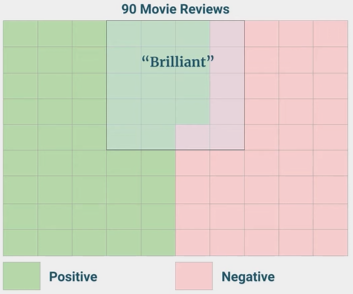

Probability of positive review, given "brilliant" in text.
* P( Positive ) = $\frac {49} {90}$
* P( Brilliant | Positive ) = $\frac {14} {49}$
* P( Brilliant ) = $\frac {20} {90}$

Then:

$P( Positive | Brilliant) = \frac {14} {49} \cdot \frac{49/90}{20/90} = 0.7$

## Applying to text classification

The *likelihood* is the probability of a particular sequence of words given a class. But it's tricky to estimate the probability of every sequence of words beacuse we need a unrealistic amount of data. To handle this we adopt two simplified assumptions:
1. **Word order doesn't matter**. We'll just ude bag of words representation
2. **Word appearence are independent of each other given a particular class**. This is a **naive** assumption, where the naive Bayes come from.

### Naive Assumption

It's called naive beacuse the assumption doesn't hold up in real life.

**Ex.:** The word "thank" and "you" are correlated, but for classification purposes it's holds up well.

*So, instead of calcululate the likelihood of a sequence of words given a class:*

$(d|c)= P([w_{1}, w_{2}, w_{3}, ... , w_{n}]|c) $

*We do calculus of a particular word occuring given a class, multiplyng each individual word probability together:*

$(d|c)= P([(w_{1}|c), (w_{2}|c), (w_{3}|c), ... , (w_{n}|c)]) $

**This assumption needs some adjustment** because multipling a lot of small probabilies together can lead to a underflow, where the number it's so tiny that our computers can't represent it in memory.

To deal with this we use log based instead:

$logP(c) + \sum_{i=1}^{n}logP(w_{i}|c)$


### Example
Find most probable class for "vaccine trial"

In [1]:
import pandas as pd
from math import log, exp
from collections import defaultdict

In [2]:
document = [
    'Beyond the pandemic',
    'Compelling jumble of philosophy',
    'Vaccine rollout enters second phase',
    'Man regains sight with implant',
    'My toilet is haunted'
]
doc_class = ['Medical', 'Not medical', 'Medical', 'Medical', 'Not medical']

corpus = pd.DataFrame([document, doc_class]).T
corpus.columns = ['document', 'class']
corpus

,document,class
0,Beyond the pandemic,Medical
1,Compelling jumble of philosophy,Not medical
2,Vaccine rollout enters second phase,Medical
3,Man regains sight with implant,Medical
4,My toilet is haunted,Not medical


#### Priors $P(c)$
Probability of document being medical

In [3]:
# P(c): Probability of document being medical
P_medical = corpus['class'].value_counts().get("Medical") / corpus['class'].count()
P_notMedical = corpus['class'].value_counts().get("Not medical") / corpus['class'].count()

print(f'P(Medical):{P_medical}\nP(Not Medical):{P_notMedical}')

P(Medical):0.6
P(Not Medical):0.4


#### Likelihoods $P(w_{i}|c)$

In [4]:
def count_words(dataframe, column):
  """
  Count each word of a given dataset
  """
  count = defaultdict(lambda: 0)
  for line, text in enumerate(dataframe[column]):
    words = text.split()
    for word in words:
      if word.lower() in count:
        count[word.lower()] += 1
      else:
        count[word.lower()] = 1
  return count

In [5]:
medical_wordQuant = count_words(dataframe=corpus[corpus['class']=="Medical"], column='document')
notMedical_wordQuant = count_words(dataframe=corpus[corpus['class']!="Medical"], column='document')

In [6]:
# P(vaccine|Medical): Probability of vaccine, given medical classification
P_vaccine_medical = medical_wordQuant['vaccine'] / sum(medical_wordQuant.values())
P_vaccine_medical

0.07692307692307693

We'll have a problem if we use this simple formula, because if any of probabilities is equal to zero, the entire equation will also be 0, given the multiplication, and it will give an error since we calculate likelihood using log.

**Ex.:** If we calculate the likelihood of a expression "vaccine trial" be a medical document we'll end up with 0 probability:

In [7]:
# P(haunted|Medical): Probability of haunted, given medical classification
P_trial_medical = medical_wordQuant['trial'] / sum(medical_wordQuant.values())
P_trial_medical

0.0

To solve this problem we use a smoothing parameter $α$, often set o 1, in numerator, and the same parameter on denominator, multiplied by the size of total vocabulary |V|.

$\frac{Count\;of\;w_i\;in\;c + α}{Count\;of\;w_i\;in\;c + α|V|}$

In [8]:
# Total vocabulary
V = sum(count_words(dataframe=corpus, column='document').values())
V

21

In [9]:
P_trial_medical = (medical_wordQuant['trial'] + 1) / (sum(medical_wordQuant.values())+1*V)
P_trial_medical

0.029411764705882353

#### Result

$P(medical|S) = logP(medical) + logP(vaccine | medical) + logP(trial | medical)$

In [10]:
P_vaccine_medical = (medical_wordQuant['vaccine'] + 1) / (sum(medical_wordQuant.values())+1*V)

In [11]:
P_medical_S = log(P_medical) + log(P_vaccine_medical) + log(P_trial_medical)
P_medical_S

-6.870399492438368

$P(not\;medical|S) = logP(not\;medical) + logP(vaccine | not\;medical) + logP(trial | not\;medical)$

In [12]:
P_vaccine_notMedical = (notMedical_wordQuant['vaccine'] + 1) / (sum(notMedical_wordQuant.values())+1*V)
P_trial_notMedical = (notMedical_wordQuant['trial'] + 1) / (sum(notMedical_wordQuant.values())+1*V)

In [13]:
P_notMedical_S = log(P_notMedical) + log(P_vaccine_notMedical) + log(P_trial_notMedical)
P_notMedical_S

-7.650882391847103

Converting to probabilities

In [14]:
exp(P_medical_S)

0.001038062283737024

In [15]:
exp(P_notMedical_S)

0.0004756242568370986

In [16]:
# P(medical | S)
exp(P_medical_S) / (exp(P_medical_S) + exp(P_notMedical_S))

0.6857841804838272